<h1>Classification Analysis on Textual Data</h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pprint
from sklearn.datasets import fetch_20newsgroups

<h2>20 Newsgroups Dataset</h2>

In [28]:
newsgroups = fetch_20newsgroups(subset='all')
print(newsgroups.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [3]:
comp_tech_category = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_category = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
eight_train = fetch_20newsgroups(subset='train', categories=comp_tech_category+rec_category, shuffle=True, random_state=42, remove=('headers','footers','quotes'))
eight_test = fetch_20newsgroups(subset='test', categories=comp_tech_category+rec_category, shuffle=True, random_state=42, remove=('headers','footers','quotes'))
all_eight_data = fetch_20newsgroups(subset='all', categories=comp_tech_category+rec_category, shuffle=True, random_state=42, remove=('headers','footers','quotes'))

<h2>Part a: Histogram of # training documents</h2>


Train subset


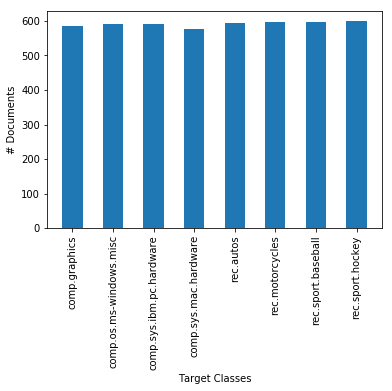

[('comp.graphics', 584),
 ('comp.os.ms-windows.misc', 591),
 ('comp.sys.ibm.pc.hardware', 590),
 ('comp.sys.mac.hardware', 578),
 ('rec.autos', 594),
 ('rec.motorcycles', 598),
 ('rec.sport.baseball', 597),
 ('rec.sport.hockey', 600)]
4732
591.5


In [4]:
# Part a
def plot_histogram(data):
    bins = np.linspace(0,7, num=16)
    plt.hist(data.target, bins=bins)
    plt.xticks([bins[i]for i in range(0, len(bins),2)] + bins[1]/2., data.target_names, rotation=90)
    plt.xlabel("Target Classes")
    plt.ylabel("# Documents")
    plt.show()
    h = np.histogram(data.target, bins=np.arange(9))
    pp = pprint.PrettyPrinter(width=40, compact=True)
    pp.pprint([(data.target_names[i], h[0][i]) for i in range(8)])
    print(np.sum([h[0][i] for i in range(8)]))
    print(np.mean([h[0][i] for i in range(8)]))
    
#print("\nAll subsets")
#plot_histogram(all_eight_data)
print("\nTrain subset")
plot_histogram(eight_train)
#print("\nTest subset")
#plot_histogram(eight_test)

<h2>Modelling Text Data and Feature Extraction</h2>

In [5]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [6]:
# Tokenizer function
def tokenize(data):
    # Convert list data to string
    raw = "".join(doc for doc in data)
    # Split into words
    tokens = word_tokenize(raw)
    # Convert to lower case
    tokens = [w.lower() for w in tokens]
    # Remove punctuation and keep on alphanumeric tokens
    punctuations = list(string.punctuation)
    punctuations.append("''")
    words = [word for word in tokens if word not in punctuations]
    words = [word for word in words if word.isalpha()]
    # Filter out stopwords
    stop_words = text.ENGLISH_STOP_WORDS
    words = [w for w in words if not w in stop_words]
    # Stemming
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(word) for word in words]
    return stemmed  

<h2>Part b: TFxIDF vector representations</h2>

In [7]:
# Function that returns TFxIDF representations
def vectorize(df, modeldata):
    print("Min df: ", df)
    vectorizer = CountVectorizer(analyzer="word", tokenizer=tokenize, min_df=df, stop_words="english")
    X_train_counts = vectorizer.fit_transform(modeldata.data)
    tfidf_transformer = TfidfTransformer(smooth_idf=False)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    print("TFIDF shape: ", X_train_tfidf.shape)
    print("Terms extracted: ", X_train_tfidf.shape[1])
    return X_train_tfidf

In [8]:
# Part b
min_df = [2,5,10]
print("\nSubset: All")
for df in min_df:
    v = vectorize(df, all_eight_data)
print("\nSubset: Train")
for df in min_df:
    v = vectorize(df, eight_train)


Subset: All
Min df:  2
TFIDF shape:  (7882, 13799)
Terms extracted:  13799
Min df:  5
TFIDF shape:  (7882, 6857)
Terms extracted:  6857
Min df:  10
TFIDF shape:  (7882, 4181)
Terms extracted:  4181

Subset: Train
Min df:  2
TFIDF shape:  (4732, 10415)
Terms extracted:  10415
Min df:  5
TFIDF shape:  (4732, 4971)
Terms extracted:  4971
Min df:  10
TFIDF shape:  (4732, 2950)
Terms extracted:  2950


<h2>Part c: TFxICF 10 most significant terms</h2>

In [30]:
# Collects all documents for each of the 20 categories
all_docs_per_category={}

for cat in newsgroups.target_names:
    categories=[cat]
    all_docs_per_category[cat] = ""
    all_data = fetch_20newsgroups(subset='train',categories=categories, shuffle=True, random_state=42, remove=('headers','footers','quotes'))
    temp = ""
    for doc in all_data.data:
        temp= temp + " "+doc
    all_docs_per_category[cat] = temp

In [35]:
import collections

# Function that returns the class frequency
def getCF(term):
    ncount = 0
    for cat in newsgroups.target_names:
        if all_docs_per_category[cat].find(term) != -1:
            ncount = ncount + 1
    return ncount

# Function that returns the term frequecy for a particular class
def getTF(term, category):
    icf = all_docs_per_category[category].count(" "+term+" ")
    return icf

# Function that returns the Inverse Class Frequency for a term in the given category
def getICF(term, category, nclasses):
    cf = getCF(term)
    icf = 0
    if cf == 0:
        icf = 1
    else:
        icf = np.log(nclasses/cf) + 1
    return icf

# Function that prints the 10 most significant terms for a caegory
def getTFxICF(category):
    tficf = {}
    nclasses = 20.0
    raw = all_docs_per_category[category]
    # Split into words
    tokens = raw.strip().split()
    #tokens = word_tokenize(raw)
    # Convert to lower case
    tokens = [w.lower() for w in tokens]
    # Remove punctuation and keep on alphanumeric tokens
    punctuations = list(string.punctuation)
    punctuations.append("''")
    words = [word for word in tokens if word not in punctuations]
    words = [word for word in words if word.isalpha()]
    # Filter out stopwords
    stop_words_skt = text.ENGLISH_STOP_WORDS
    from nltk.corpus import stopwords
    #nltk.download('stopwords' )
    stop_words_en = stopwords.words('english')
    combined_stopwords = set.union(set(stop_words_en),set(punctuations),set(stop_words_skt))
    new_words = []
    for w in words:
        if w in combined_stopwords:
            continue
        else:
            new_words.append(w)
    for term in new_words:
        if term in tficf:
            continue
        tficf[term] = getTF(term, category)*getICF(term, category, nclasses)
              
    d = collections.Counter(tficf)
    print("Most common 10 terms in ",category,": ", d.most_common(10))
    return

In [36]:
# Part c
check = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']
for c in check:
    getTFxICF(c)

Most common 10 terms in  comp.sys.ibm.pc.hardware :  [('drive', 310.0), ('controller', 259.05151862567163), ('disk', 189.49058550813731), ('use', 181.0), ('drives', 170.01695363267515), ('card', 161.0), ('floppy', 158.26867726716392), ('know', 152.0), ('hard', 138.0), ('like', 137.0)]
Most common 10 terms in  comp.sys.mac.hardware :  [('use', 138.0), ('know', 135.0), ('like', 133.0), ('drive', 110.0), ('problem', 96.0), ('new', 84.0), ('disk', 73.238692558359816), ('used', 73.0), ('need', 72.0), ('monitor', 71.903772028752826)]
Most common 10 terms in  misc.forsale :  [('new', 107.0), ('like', 99.0), ('sell', 89.0), ('shipping', 84.113846524201406), ('following', 66.0), ('used', 65.0), ('best', 65.0), ('good', 63.0), ('price', 61.0), ('interested', 61.0)]
Most common 10 terms in  soc.religion.christian :  [('people', 311.0), ('think', 259.0), ('believe', 240.0), ('know', 230.0), ('like', 211.0), ('say', 188.0), ('faith', 186.00177909201906), ('church', 168.63358440492564), ('good', 153

<h2>Feature Selection</h2>

In [37]:
from sklearn.decomposition import TruncatedSVD

# Function that returns LSI representation
def getLSI(df, categories):
    train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42, remove=('headers','footers','quotes'))
    test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42, remove=('headers','footers','quotes'))
    print("\nMin df: ", df)
    vect = CountVectorizer(analyzer="word", tokenizer=tokenize, min_df=df, stop_words="english")
    X_train_counts = vect.fit_transform(train.data)
    X_test_counts = vect.transform(test.data)
    tfidf_transformer = TfidfTransformer(smooth_idf=False)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
    svd_train = svd.fit_transform(X_train_tfidf)
    svd_test = svd.transform(X_test_tfidf)
    return svd_train, svd_test

In [38]:
from sklearn.decomposition import NMF

# Function that returns NMF representation
def getNMF(df, categories):
    train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42, remove=('headers','footers','quotes'))
    test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42, remove=('headers','footers','quotes'))
    print("\nMin df: ", df)
    vect = CountVectorizer(analyzer="word", tokenizer=tokenize, min_df=df, stop_words="english")
    X_train_counts = vect.fit_transform(train.data)
    X_test_counts = vect.transform(test.data)
    tfidf_transformer = TfidfTransformer(smooth_idf=False)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    nmf = NMF(n_components=50, init='random', random_state=42)
    nmf_train = nmf.fit_transform(X_train_tfidf)
    nmf_test = nmf.transform(X_test_tfidf)
    return nmf_train, nmf_test

<h2>Part d: LSI and NMF representations

In [39]:
# Part d
for df in min_df:
    svd_train, svd_test = getLSI(df, comp_tech_category+rec_category)
    print("LSI Train shape: ", svd_train.shape)
    print("LSI Test shape: ", svd_test.shape)
    nmf_train, nmf_test = getNMF(df, comp_tech_category+rec_category)
    print("NMF Train shape: ", nmf_train.shape)
    print("NMF Test shape: ", nmf_test.shape)
    


Min df:  2
LSI Train shape:  (4732, 50)
LSI Test shape:  (3150, 50)

Min df:  2
NMF Train shape:  (4732, 50)
NMF Test shape:  (3150, 50)

Min df:  5
LSI Train shape:  (4732, 50)
LSI Test shape:  (3150, 50)

Min df:  5
NMF Train shape:  (4732, 50)
NMF Test shape:  (3150, 50)


<h2>Learning Algorithms</h2>

In [3]:
# Functions to calculate and plot performance metrics
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def performance_metrics(y_pred, y_test, y_score, categories=["Computer Tech", "Recreational"], normalization=True):
    print("Precision Score: ", precision_score(y_test, y_pred))
    print("Recall Score: ", recall_score(y_test, y_pred))
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), categories, normalization)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr,tpr, roc_auc)

<h2>Part e: Hard margin and Soft margin SVM classifier</h2>

In [51]:
#Getting the LSI and NMF Vectors used in further sections
lsi_2_train, lsi_2_test = getLSI(2,comp_tech_category+rec_category) #LSI with min df = 2
lsi_5_train, lsi_5_test = getLSI(5,comp_tech_category+rec_category) #LSI with min df = 5
nmf_train, nmf_test = getNMF(2,comp_tech_category+rec_category) #NMF with min df = 2


Min df:  2

Min df:  5

Min df:  2


In [11]:
nmf_train, nmf_test = getNMF(2,comp_tech_category+rec_category) #NMF with min df = 2


Min df:  2


In [52]:
#Part e
from sklearn.svm import LinearSVC
print("HARD SVM : C = 1000")
print("LSI with min df = 2")
#We want to separate the documents into 2 groups - Computer Tech and Recreational instead of 8 subclasses
Y_train = [int(i/4) for i in eight_train.target]
Y_test = [int(i/4) for i in eight_test.target]
hard_svm = LinearSVC(C=1000)
hard_svm.fit(lsi_2_train,Y_train)
hard_svm_preds = hard_svm.predict(lsi_2_test)
print("Predictions:",hard_svm_preds)

HARD SVM : C = 1000
LSI with min df = 2
Predictions: [0 0 0 ..., 1 0 0]


In [13]:
Y_train = [int(i/4) for i in eight_train.target]
Y_test = [int(i/4) for i in eight_test.target]

Precision Score:  0.916067146283
Recall Score:  0.961006289308
Accuracy Score:  0.935873015873
Normalized confusion matrix
[[ 0.91025641  0.08974359]
 [ 0.03899371  0.96100629]]


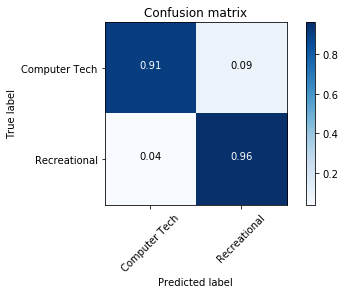

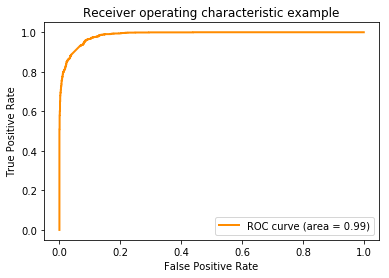

In [53]:
Y_score = hard_svm.decision_function(lsi_2_test)
performance_metrics(hard_svm_preds,Y_test,Y_score)

In [54]:
print("HARD SVM : C = 1000")
print("LSI with min df = 5")
hard_svm = LinearSVC(C=1000)
hard_svm.fit(lsi_5_train,Y_train)
hard_svm_preds = hard_svm.predict(lsi_5_test)
print("Predictions:",hard_svm_preds)

HARD SVM : C = 1000
LSI with min df = 5
Predictions: [0 0 0 ..., 1 0 0]


Precision Score:  0.909520993495
Recall Score:  0.967295597484
Accuracy Score:  0.934920634921
Normalized confusion matrix
[[ 0.90192308  0.09807692]
 [ 0.0327044   0.9672956 ]]


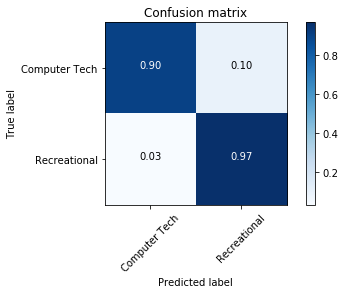

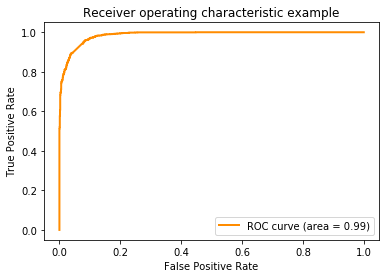

In [55]:
Y_score = hard_svm.decision_function(lsi_5_test)
performance_metrics(hard_svm_preds,Y_test,Y_score)

In [20]:
print("HARD SVM : C = 1000")
print("NMF with min df = 2")
hard_svm = LinearSVC(C=1000)
hard_svm.fit(nmf_train,Y_train)
hard_svm_preds = hard_svm.predict(nmf_test)
print("Predictions:",hard_svm_preds)

HARD SVM : C = 1000
NMF with min df = 2
Predictions: [0 0 0 ..., 1 0 0]


Precision Score:  0.857851239669
Recall Score:  0.979245283019
Accuracy Score:  0.907619047619
Normalized confusion matrix
[[ 0.83461538  0.16538462]
 [ 0.02075472  0.97924528]]


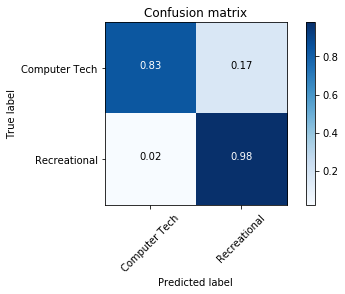

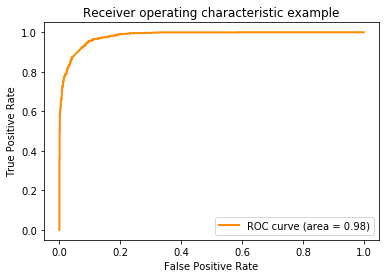

In [21]:
Y_score = hard_svm.decision_function(nmf_test)
performance_metrics(hard_svm_preds,Y_test,Y_score)

In [58]:
print("SOFT SVM : C = 0.001")
print("LSI with min df = 2")
soft_svm = LinearSVC(C=0.001)
soft_svm.fit(lsi_2_train,Y_train)
soft_svm_preds = soft_svm.predict(lsi_2_test)
print("Predictions:",soft_svm_preds)

SOFT SVM : C = 0.001
LSI with min df = 2
Predictions: [0 0 1 ..., 1 0 0]


Precision Score:  0.819895287958
Recall Score:  0.984905660377
Accuracy Score:  0.883174603175
Normalized confusion matrix
[[ 0.77948718  0.22051282]
 [ 0.01509434  0.98490566]]


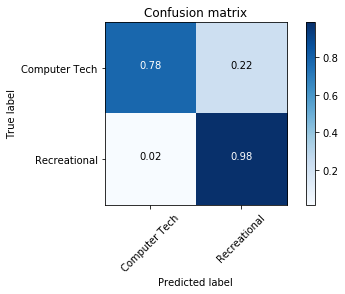

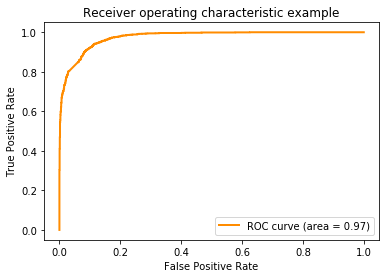

In [59]:
Y_score = soft_svm.decision_function(lsi_2_test)
performance_metrics(soft_svm_preds,Y_test,Y_score)

In [60]:
print("SOFT SVM : C = 0.001")
print("LSI with min df = 5")
soft_svm = LinearSVC(C=0.001)
soft_svm.fit(lsi_5_train,Y_train)
soft_svm_preds = soft_svm.predict(lsi_5_test)
print("Predictions:",soft_svm_preds)

SOFT SVM : C = 0.001
LSI with min df = 5
Predictions: [0 0 1 ..., 1 0 0]


Precision Score:  0.826433121019
Recall Score:  0.979245283019
Accuracy Score:  0.885714285714
Normalized confusion matrix
[[ 0.79038462  0.20961538]
 [ 0.02075472  0.97924528]]


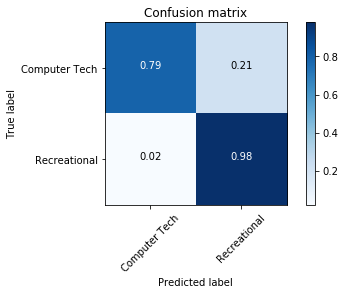

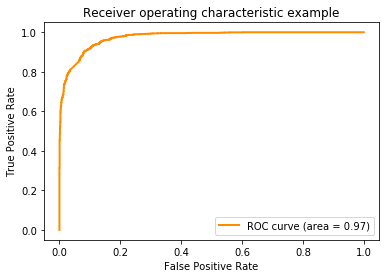

In [61]:
Y_score = soft_svm.decision_function(lsi_5_test)
performance_metrics(soft_svm_preds,Y_test,Y_score)

In [14]:
from sklearn.svm import LinearSVC
print("SOFT SVM : C = 0.001")
print("NMF with min df = 2")
soft_svm = LinearSVC(C=0.001)
soft_svm.fit(nmf_train,Y_train)
soft_svm_preds = soft_svm.predict(nmf_test)
print("Predictions:",soft_svm_preds)

SOFT SVM : C = 0.001
NMF with min df = 2
Predictions: [1 1 1 ..., 1 0 0]


Precision Score:  0.574174827711
Recall Score:  0.995597484277
Accuracy Score:  0.625079365079
Normalized confusion matrix
[[ 0.2474359   0.7525641 ]
 [ 0.00440252  0.99559748]]


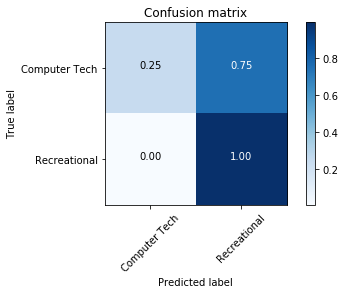

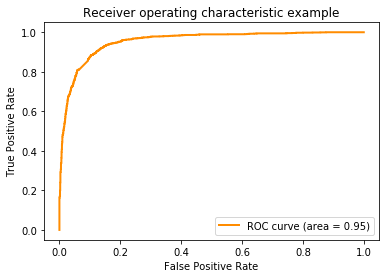

In [15]:
Y_score = soft_svm.decision_function(nmf_test)
performance_metrics(soft_svm_preds,Y_test,Y_score)

<h2>Part f: 5-fold cross-validation</h2>

In [101]:
#Part f
print("LSI with min df = 2")
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
parameters = {'C':[0.0001,0.001,0.1,1,10,100,1000]}
clf = GridSearchCV(LinearSVC(), parameters, cv=5)
clf.fit(lsi_2_train,Y_train)
print("Best Parameter : ",clf.best_params_)

LSI with min df = 2
Best Parameter :  {'C': 100}


Precision Score:  0.917717717718
Recall Score:  0.961006289308
Accuracy Score:  0.936825396825
Normalized confusion matrix
[[ 0.91217949  0.08782051]
 [ 0.03899371  0.96100629]]


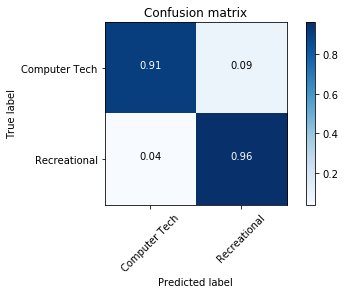

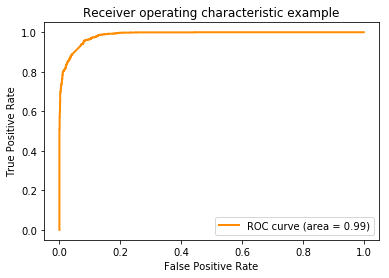

In [105]:
svc = LinearSVC(C=100)
svc.fit(lsi_2_train,Y_train)
preds = svc.predict(lsi_2_test)
Y_score = svc.decision_function(lsi_2_test)
performance_metrics(preds,Y_test,Y_score)

In [104]:
print("LSI with min df = 5")
parameters = {'C':[0.0001,0.001,0.1,1,10,100,1000]}
clf = GridSearchCV(LinearSVC(), parameters, cv=5)
clf.fit(lsi_5_train,Y_train)
print("Best Parameter : ",clf.best_params_)

LSI with min df = 5
Best Parameter :  {'C': 100}


Precision Score:  0.918121613486
Recall Score:  0.959119496855
Accuracy Score:  0.93619047619
Normalized confusion matrix
[[ 0.91282051  0.08717949]
 [ 0.0408805   0.9591195 ]]


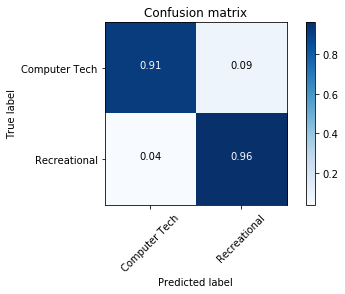

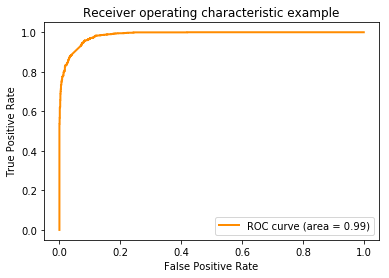

In [106]:
svc = LinearSVC(C=100)
svc.fit(lsi_5_train,Y_train)
preds = svc.predict(lsi_5_test)
Y_score = svc.decision_function(lsi_5_test)
performance_metrics(preds,Y_test,Y_score)

In [16]:
from sklearn.model_selection import GridSearchCV
print("NMF with min df = 2")
parameters = {'C':[0.0001,0.001,0.1,1,10,100,1000]}
clf = GridSearchCV(LinearSVC(), parameters, cv=5)
clf.fit(nmf_train,Y_train)
print("Best Parameter : ",clf.best_params_)

NMF with min df = 2
Best Parameter :  {'C': 100}


Precision Score:  0.90053285968
Recall Score:  0.956603773585
Accuracy Score:  0.924761904762
Normalized confusion matrix
[[ 0.89230769  0.10769231]
 [ 0.04339623  0.95660377]]


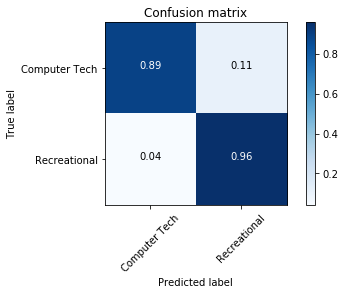

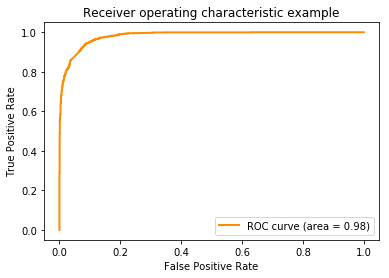

In [17]:
svc = LinearSVC(C=100)
svc.fit(nmf_train,Y_train)
preds = svc.predict(nmf_test)
Y_score = svc.decision_function(nmf_test)
performance_metrics(preds,Y_test,Y_score)

<h2>Part g: Naive Bayes classifier</h2>

Naive Bayes
LSI with min df = 2
Precision Score:  0.737179487179
Recall Score:  0.940251572327
Accuracy Score:  0.800634920635
Normalized confusion matrix
[[ 0.65833333  0.34166667]
 [ 0.05974843  0.94025157]]


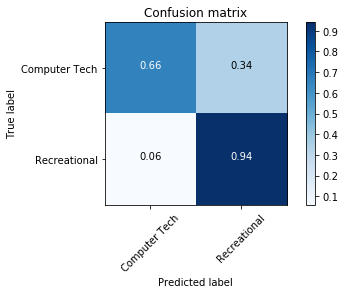

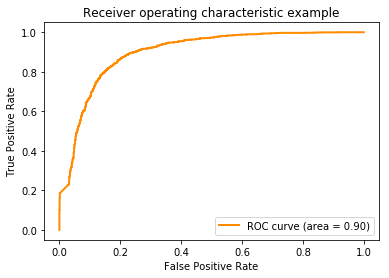

In [64]:
#Part g
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
print("Naive Bayes")
print("LSI with min df = 2")
nbclassifier = GaussianNB()
nbclassifier.fit(lsi_2_train,Y_train)
nb_preds = nbclassifier.predict(lsi_2_test)
Y_score = nbclassifier.predict_proba(lsi_2_test)
performance_metrics(nb_preds,Y_test,Y_score[:,1])

Naive Bayes
LSI with min df = 5
Precision Score:  0.743182944968
Recall Score:  0.942767295597
Accuracy Score:  0.806666666667
Normalized confusion matrix
[[ 0.66794872  0.33205128]
 [ 0.0572327   0.9427673 ]]


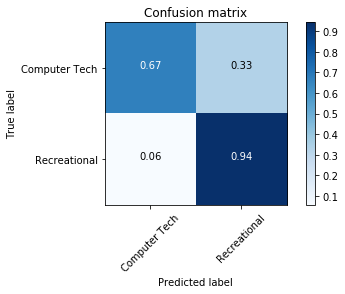

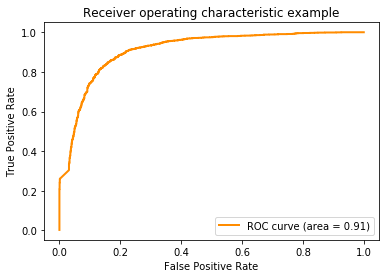

In [65]:
print("Naive Bayes")
print("LSI with min df = 5")
nbclassifier = GaussianNB()
nbclassifier.fit(lsi_5_train,Y_train)
nb_preds = nbclassifier.predict(lsi_5_test)
Y_score = nbclassifier.predict_proba(lsi_5_test)
performance_metrics(nb_preds,Y_test,Y_score[:,1])

NMF with min df = 2
Precision Score:  0.840108401084
Recall Score:  0.974842767296
Accuracy Score:  0.893650793651
Normalized confusion matrix
[[ 0.81089744  0.18910256]
 [ 0.02515723  0.97484277]]


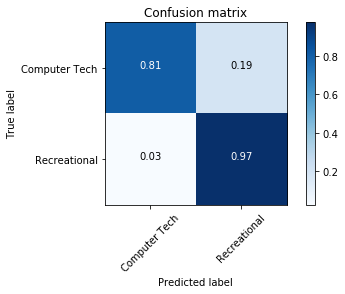

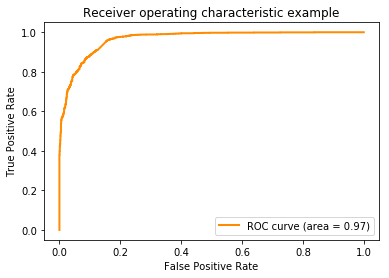

In [67]:
print("NMF with min df = 2")
nbclassifier = MultinomialNB()
nbclassifier.fit(nmf_train,Y_train)
nb_preds = nbclassifier.predict(nmf_test)
Y_score = nbclassifier.predict_proba(nmf_test)
performance_metrics(nb_preds,Y_test,Y_score[:,1])

<h2>Part h: Logistic Regression Classifer</h2>

Logistic Regression Classifier
LSI with min df = 2
Precision Score:  0.888374783112
Recall Score:  0.966037735849
Accuracy Score:  0.921587301587
Normalized confusion matrix
[[ 0.87628205  0.12371795]
 [ 0.03396226  0.96603774]]


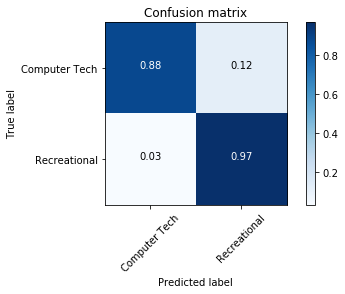

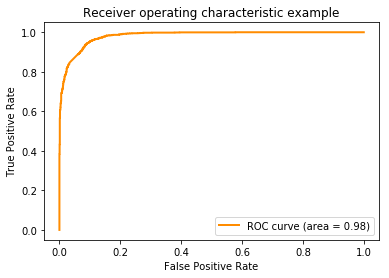

In [68]:
#Part h
print("Logistic Regression Classifier")
print("LSI with min df = 2")
from sklearn.linear_model import LogisticRegression
lrclassifier = LogisticRegression()
lrclassifier.fit(lsi_2_train,Y_train)
lr_preds = lrclassifier.predict(lsi_2_test)
Y_score = lrclassifier.predict_proba(lsi_2_test)
performance_metrics(lr_preds,Y_test,Y_score[:,1])

Logistic Regression Classifier
LSI with min df = 5
Precision Score:  0.890887986071
Recall Score:  0.965408805031
Accuracy Score:  0.922857142857
Normalized confusion matrix
[[ 0.87948718  0.12051282]
 [ 0.03459119  0.96540881]]


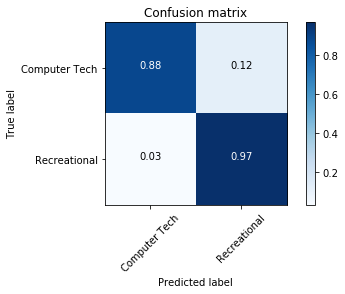

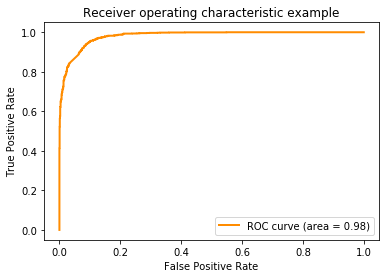

In [69]:
print("Logistic Regression Classifier")
print("LSI with min df = 5")
lrclassifier = LogisticRegression()
lrclassifier.fit(lsi_5_train,Y_train)
lr_preds = lrclassifier.predict(lsi_5_test)
Y_score = lrclassifier.predict_proba(lsi_5_test)
performance_metrics(lr_preds,Y_test,Y_score[:,1])

Logistic Regression Classifier
NMF with min df = 2
Precision Score:  0.81717597471
Recall Score:  0.975471698113
Accuracy Score:  0.87746031746
Normalized confusion matrix
[[ 0.7775641  0.2224359]
 [ 0.0245283  0.9754717]]


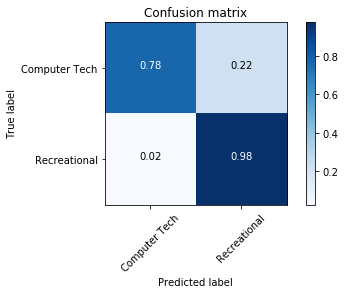

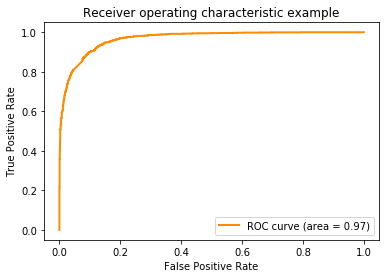

In [70]:
print("Logistic Regression Classifier")
print("NMF with min df = 2")
lrclassifier = LogisticRegression()
lrclassifier.fit(nmf_train,Y_train)
lr_preds = lrclassifier.predict(nmf_test)
Y_score = lrclassifier.predict_proba(nmf_test)
performance_metrics(lr_preds,Y_test,Y_score[:,1])

<h2>Part i: L1 and L2 regularized Logistic Regression</h2>

In [82]:
#Part i
print("Logistic Regression with L1 Norm")
print("LSI with min df = 2")
coef = [0.001,0.01,0.1,1,10,100,1000]
acc=[]
for c in coef:
    lr1_classifier = LogisticRegression(penalty='l1',C=c)
    lr1_classifier.fit(lsi_2_train,Y_train)
    lr1_preds = lr1_classifier.predict(lsi_2_test)
    print("Regularization Coefficient : ",c)
    print("Accuracy Score: ", accuracy_score(Y_test, lr1_preds))
    acc.append(accuracy_score(Y_test, lr1_preds))
print("Best Coefficient Value : ",coef[acc.index(max(acc))])

Logistic Regression with L1 Norm
LSI with min df = 2
Regularization Coefficient :  0.001
Accuracy Score:  0.495238095238
Regularization Coefficient :  0.01
Accuracy Score:  0.858412698413
Regularization Coefficient :  0.1
Accuracy Score:  0.895238095238
Regularization Coefficient :  1
Accuracy Score:  0.924761904762
Regularization Coefficient :  10
Accuracy Score:  0.935238095238
Regularization Coefficient :  100
Accuracy Score:  0.935555555556
Regularization Coefficient :  1000
Accuracy Score:  0.935555555556
Best Coefficient :  100


Regularization Coefficient :  100
Precision Score:  0.917519566526
Recall Score:  0.958490566038
Accuracy Score:  0.935555555556
Normalized confusion matrix
[[ 0.91217949  0.08782051]
 [ 0.04150943  0.95849057]]


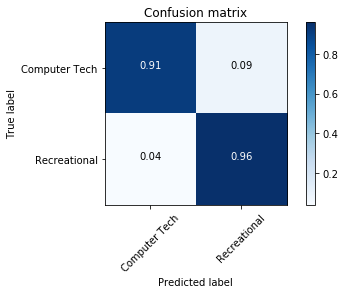

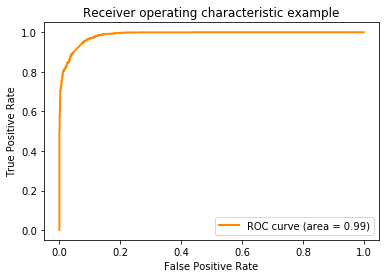

In [72]:
#Best score for C = 100
lr1_classifier = LogisticRegression(penalty='l1',C=100)
lr1_classifier.fit(lsi_2_train,Y_train)
lr1_preds = lr1_classifier.predict(lsi_2_test)
print("Regularization Coefficient : ",100)
Y_score = lr1_classifier.predict_proba(lsi_2_test)
performance_metrics(lr1_preds,Y_test,Y_score[:,1])

In [83]:
print("Logistic Regression with L1 Norm")
print("LSI with min df = 5")
coef = [0.001,0.01,0.1,1,10,100,1000]
acc=[]
for c in coef:
    lr1_classifier = LogisticRegression(penalty='l1',C=c)
    lr1_classifier.fit(lsi_5_train,Y_train)
    lr1_preds = lr1_classifier.predict(lsi_5_test)
    print("Regularization Coefficient : ",c)
    print("Accuracy Score: ", accuracy_score(Y_test, lr1_preds))
    acc.append(accuracy_score(Y_test, lr1_preds))
print("Best Coefficient Value : ",coef[acc.index(max(acc))])

Logistic Regression with L1 Norm
LSI with min df = 5
Regularization Coefficient :  0.001
Accuracy Score:  0.495238095238
Regularization Coefficient :  0.01
Accuracy Score:  0.86
Regularization Coefficient :  0.1
Accuracy Score:  0.89619047619
Regularization Coefficient :  1
Accuracy Score:  0.926349206349
Regularization Coefficient :  10
Accuracy Score:  0.934920634921
Regularization Coefficient :  100
Accuracy Score:  0.93619047619
Regularization Coefficient :  1000
Accuracy Score:  0.936507936508
Best Coefficient Value :  1000


Regularization Coefficient :  1000
Precision Score:  0.918674698795
Recall Score:  0.959119496855
Accuracy Score:  0.936507936508
Normalized confusion matrix
[[ 0.91346154  0.08653846]
 [ 0.0408805   0.9591195 ]]


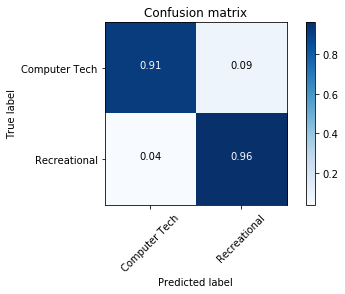

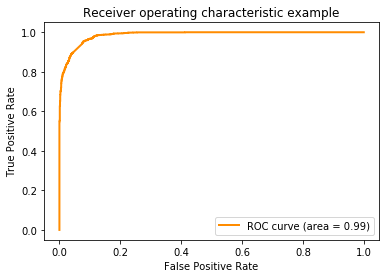

In [74]:
#Best score for C = 1000
lr1_classifier = LogisticRegression(penalty='l1',C=1000)
lr1_classifier.fit(lsi_5_train,Y_train)
lr1_preds = lr1_classifier.predict(lsi_5_test)
print("Regularization Coefficient : ",1000)
Y_score = lr1_classifier.predict_proba(lsi_5_test)
performance_metrics(lr1_preds,Y_test,Y_score[:,1])

In [84]:
print("Logistic Regression with L1 Norm")
print("NMF with min df = 2")
coef = [0.001,0.01,0.1,1,10,100,1000]
acc=[]
for c in coef:
    lr1_classifier = LogisticRegression(penalty='l1',C=c)
    lr1_classifier.fit(nmf_train,Y_train)
    lr1_preds = lr1_classifier.predict(nmf_test)
    print("Regularization Coefficient : ",c)
    print("Accuracy Score: ", accuracy_score(Y_test, lr1_preds))
    acc.append(accuracy_score(Y_test, lr1_preds))
print("Best Coefficient Value : ",coef[acc.index(max(acc))])

Logistic Regression with L1 Norm
NMF with min df = 2
Regularization Coefficient :  0.001
Accuracy Score:  0.495238095238
Regularization Coefficient :  0.01
Accuracy Score:  0.495238095238
Regularization Coefficient :  0.1
Accuracy Score:  0.674603174603
Regularization Coefficient :  1
Accuracy Score:  0.913968253968
Regularization Coefficient :  10
Accuracy Score:  0.92380952381
Regularization Coefficient :  100
Accuracy Score:  0.929523809524
Regularization Coefficient :  1000
Accuracy Score:  0.928888888889
Best Coefficient Value :  100


Regularization Coefficient :  100
Precision Score:  0.909526662672
Recall Score:  0.954716981132
Accuracy Score:  0.929206349206
Normalized confusion matrix
[[ 0.90320513  0.09679487]
 [ 0.04528302  0.95471698]]


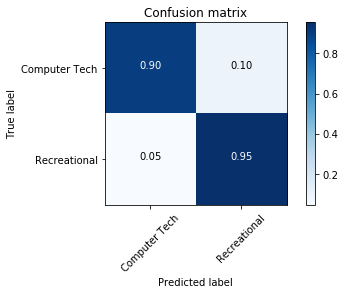

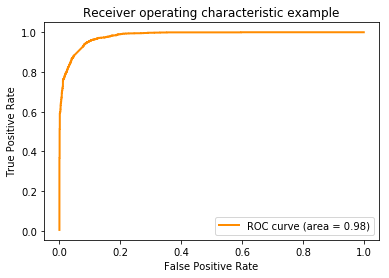

In [76]:
#Best score for C = 100
lr1_classifier = LogisticRegression(penalty='l1',C=100)
lr1_classifier.fit(nmf_train,Y_train)
lr1_preds = lr1_classifier.predict(nmf_test)
print("Regularization Coefficient : ",100)
Y_score = lr1_classifier.predict_proba(nmf_test)
performance_metrics(lr1_preds,Y_test,Y_score[:,1])

In [87]:
print("Logistic Regression with L2 Norm")
print("LSI with min df = 2")
coef = [0.001,0.01,0.1,1,10,100,1000]
acc=[]
for c in coef:
    lr2_classifier = LogisticRegression(penalty='l2',C=c)
    lr2_classifier.fit(lsi_2_train,Y_train)
    lr2_preds = lr2_classifier.predict(lsi_2_test)
    print("Regularization Coefficient : ",c)
    print("Accuracy Score: ", accuracy_score(Y_test, lr2_preds))
    acc.append(accuracy_score(Y_test, lr2_preds))
print("Best Coefficient Value : ",coef[acc.index(max(acc))])

Logistic Regression with L2 Norm
LSI with min df = 2
Regularization Coefficient :  0.001
Accuracy Score:  0.766666666667
Regularization Coefficient :  0.01
Accuracy Score:  0.886349206349
Regularization Coefficient :  0.1
Accuracy Score:  0.906984126984
Regularization Coefficient :  1
Accuracy Score:  0.921587301587
Regularization Coefficient :  10
Accuracy Score:  0.931746031746
Regularization Coefficient :  100
Accuracy Score:  0.934920634921
Regularization Coefficient :  1000
Accuracy Score:  0.935555555556
Best Coefficient Value :  1000


Regularization Coefficient :  1000
Precision Score:  0.917017438364
Recall Score:  0.959119496855
Accuracy Score:  0.935555555556
Normalized confusion matrix
[[ 0.91153846  0.08846154]
 [ 0.0408805   0.9591195 ]]


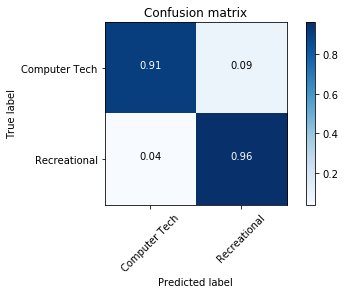

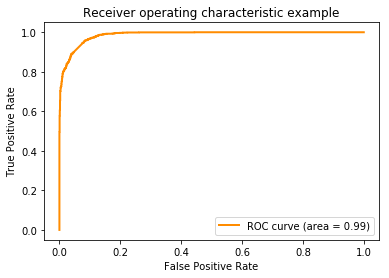

In [89]:
#Best score with C = 1000 
lr2_classifier = LogisticRegression(penalty='l2',C=1000)
lr2_classifier.fit(lsi_2_train,Y_train)
lr2_preds = lr2_classifier.predict(lsi_2_test)
print("Regularization Coefficient : ",1000)
Y_score = lr2_classifier.predict_proba(lsi_2_test)
performance_metrics(lr2_preds,Y_test,Y_score[:,1])

In [90]:
print("Logistic Regression with L2 Norm")
print("LSI with min df = 5")
coef = [0.001,0.01,0.1,1,10,100,1000]
acc=[]
for c in coef:
    lr2_classifier = LogisticRegression(penalty='l2',C=c)
    lr2_classifier.fit(lsi_5_train,Y_train)
    lr2_preds = lr2_classifier.predict(lsi_5_test)
    print("Regularization Coefficient : ",c)
    print("Accuracy Score: ", accuracy_score(Y_test, lr2_preds))
    acc.append(accuracy_score(Y_test, lr2_preds))
print("Best Coefficient Value : ",coef[acc.index(max(acc))])

Logistic Regression with L2 Norm
LSI with min df = 5
Regularization Coefficient :  0.001
Accuracy Score:  0.787301587302
Regularization Coefficient :  0.01
Accuracy Score:  0.888571428571
Regularization Coefficient :  0.1
Accuracy Score:  0.907301587302
Regularization Coefficient :  1
Accuracy Score:  0.922857142857
Regularization Coefficient :  10
Accuracy Score:  0.931746031746
Regularization Coefficient :  100
Accuracy Score:  0.935555555556
Regularization Coefficient :  1000
Accuracy Score:  0.93619047619
Best Coefficient Value :  1000


Regularization Coefficient :  1000
Precision Score:  0.918625678119
Recall Score:  0.958490566038
Accuracy Score:  0.93619047619
Normalized confusion matrix
[[ 0.91346154  0.08653846]
 [ 0.04150943  0.95849057]]


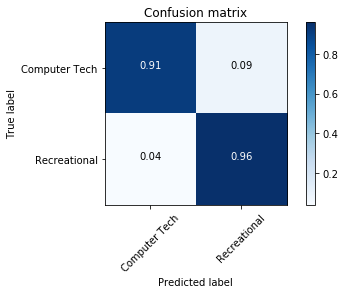

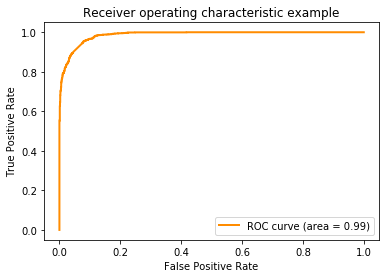

In [91]:
#Best score with C = 1000 
lr2_classifier = LogisticRegression(penalty='l2',C=1000)
lr2_classifier.fit(lsi_5_train,Y_train)
lr2_preds = lr2_classifier.predict(lsi_5_test)
print("Regularization Coefficient : ",1000)
Y_score = lr2_classifier.predict_proba(lsi_5_test)
performance_metrics(lr2_preds,Y_test,Y_score[:,1])

In [92]:
print("Logistic Regression with L2 Norm")
print("NMF with min df = 2")
coef = [0.001,0.01,0.1,1,10,100,1000]
acc=[]
for c in coef:
    lr2_classifier = LogisticRegression(penalty='l2',C=c)
    lr2_classifier.fit(nmf_train,Y_train)
    lr2_preds = lr2_classifier.predict(nmf_test)
    print("Regularization Coefficient : ",c)
    print("Accuracy Score: ", accuracy_score(Y_test, lr2_preds))
    acc.append(accuracy_score(Y_test, lr2_preds))
print("Best Coefficient Value : ",coef[acc.index(max(acc))])

Logistic Regression with L2 Norm
NMF with min df = 2
Regularization Coefficient :  0.001
Accuracy Score:  0.529841269841
Regularization Coefficient :  0.01
Accuracy Score:  0.639365079365
Regularization Coefficient :  0.1
Accuracy Score:  0.790793650794
Regularization Coefficient :  1
Accuracy Score:  0.87746031746
Regularization Coefficient :  10
Accuracy Score:  0.904761904762
Regularization Coefficient :  100
Accuracy Score:  0.917142857143
Regularization Coefficient :  1000
Accuracy Score:  0.925714285714
Best Coefficient Value :  1000


Regularization Coefficient :  1000
Precision Score:  0.904052443385
Recall Score:  0.954088050314
Accuracy Score:  0.925714285714
Normalized confusion matrix
[[ 0.89679487  0.10320513]
 [ 0.04591195  0.95408805]]


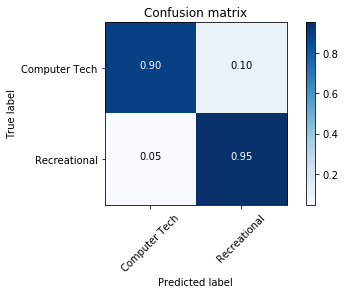

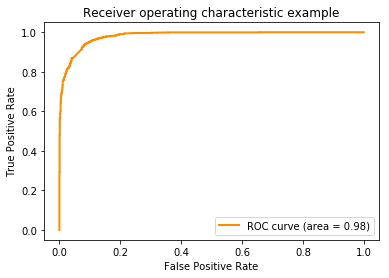

In [93]:
lr2_classifier = LogisticRegression(penalty='l2',C=1000)
lr2_classifier.fit(nmf_train,Y_train)
lr2_preds = lr2_classifier.predict(nmf_test)
print("Regularization Coefficient : ",1000)
Y_score = lr2_classifier.predict_proba(nmf_test)
performance_metrics(lr2_preds,Y_test,Y_score[:,1])

<h2>Multiclass Classification</h2>

<h2>Part j: Naive Bayes and Multiclass Classification (One VS One and One VS the rest methods)</h2>

In [109]:
#Part j
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']
train_set_j = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42, remove=('headers','footers','quotes'))
test_set_j = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42, remove=('headers','footers','quotes'))
lsi_2_train_j, lsi_2_test_j = getLSI(2,categories)
nmf_train_j, nmf_test_j = getNMF(2,categories)


Min df:  2

Min df:  2


Multiclass Naive Bayes
LSI with min df = 2
Precision Score:  0.640315022884
Recall Score:  0.638050645813
Accuracy Score:  0.640255591054
Normalized confusion matrix
[[ 0.48469388  0.16581633  0.22959184  0.11989796]
 [ 0.16883117  0.44155844  0.17142857  0.21818182]
 [ 0.12564103  0.04358974  0.64102564  0.18974359]
 [ 0.00251256  0.00251256  0.01005025  0.98492462]]


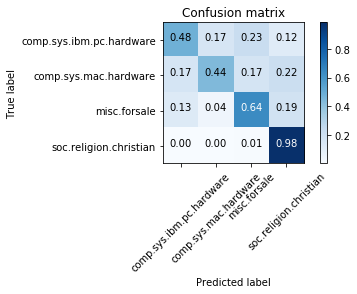

In [135]:
print("Multiclass Naive Bayes")
print("LSI with min df = 2")
multi_naive = GaussianNB()
multi_naive.fit(lsi_2_train_j,train_set_j.target)
multi_naive_preds = multi_naive.predict(lsi_2_test_j)
print("Precision Score: ", precision_score(test_set_j.target, multi_naive_preds,average='macro'))
print("Recall Score: ", recall_score(test_set_j.target, multi_naive_preds,average='macro'))
print("Accuracy Score: ", accuracy_score(test_set_j.target, multi_naive_preds))
plot_confusion_matrix(confusion_matrix(test_set_j.target, multi_naive_preds), categories, normalize = True)
plt.show()

Multiclass Naive Bayes
NMF with min df = 2
Precision Score:  0.756765801031
Recall Score:  0.753631693743
Accuracy Score:  0.755271565495
Normalized confusion matrix
[[ 0.73469388  0.1377551   0.08163265  0.04591837]
 [ 0.23116883  0.59480519  0.08571429  0.08831169]
 [ 0.14871795  0.04615385  0.70512821  0.1       ]
 [ 0.01005025  0.          0.01005025  0.9798995 ]]


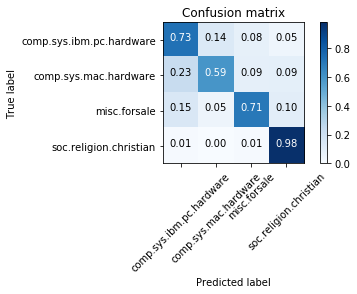

In [136]:
print("Multiclass Naive Bayes")
print("NMF with min df = 2")
multi_naive = MultinomialNB()
multi_naive.fit(nmf_train_j,train_set_j.target)
multi_naive_preds = multi_naive.predict(nmf_test_j)
print("Precision Score: ", precision_score(test_set_j.target, multi_naive_preds,average='macro'))
print("Recall Score: ", recall_score(test_set_j.target, multi_naive_preds,average='macro'))
print("Accuracy Score: ", accuracy_score(test_set_j.target, multi_naive_preds))
plot_confusion_matrix(confusion_matrix(test_set_j.target, multi_naive_preds), categories, normalize = True)
plt.show()

One Vs One Classifier - SVC
LSI with min df = 2
Precision Score:  0.814668057521
Recall Score:  0.810916197048
Accuracy Score:  0.811501597444
Normalized confusion matrix
[[ 0.72193878  0.19897959  0.07142857  0.00765306]
 [ 0.14805195  0.77402597  0.06753247  0.01038961]
 [ 0.07435897  0.08974359  0.82307692  0.01282051]
 [ 0.00753769  0.04020101  0.02763819  0.92462312]]


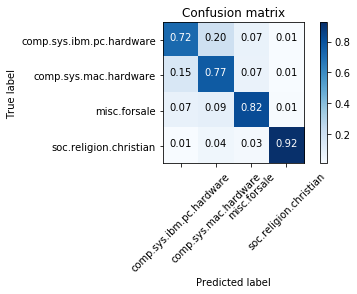

In [128]:
print("One Vs One Classifier - SVC")
print("LSI with min df = 2")
from sklearn.multiclass import OneVsOneClassifier
ovo_nb = OneVsOneClassifier(LinearSVC()).fit(lsi_2_train_j, train_set_j.target)
ovo_nb_preds = ovo_nb.predict(lsi_2_test_j)
print("Precision Score: ", precision_score(test_set_j.target, ovo_nb_preds,average='macro'))
print("Recall Score: ", recall_score(test_set_j.target, ovo_nb_preds,average='macro'))
print("Accuracy Score: ", accuracy_score(test_set_j.target, ovo_nb_preds))
plot_confusion_matrix(confusion_matrix(test_set_j.target, ovo_nb_preds), categories, normalize = True)
plt.show()

One Vs One Classifier - SVC
NMF with min df = 2
Precision Score:  0.779941990289
Recall Score:  0.77380699284
Accuracy Score:  0.774440894569
Normalized confusion matrix
[[ 0.67857143  0.17857143  0.13265306  0.01020408]
 [ 0.14545455  0.71428571  0.12987013  0.01038961]
 [ 0.11538462  0.05641026  0.81794872  0.01025641]
 [ 0.01005025  0.01256281  0.09296482  0.88442211]]


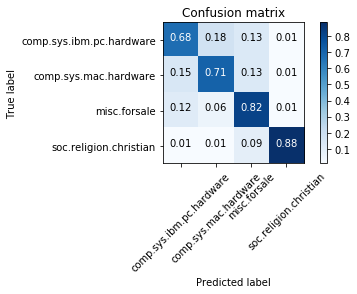

In [129]:
print("One Vs One Classifier - SVC")
print("NMF with min df = 2")
from sklearn.multiclass import OneVsOneClassifier
ovo_nb = OneVsOneClassifier(LinearSVC()).fit(nmf_train_j, train_set_j.target)
ovo_nb_preds = ovo_nb.predict(nmf_test_j)
print("Precision Score: ", precision_score(test_set_j.target, ovo_nb_preds,average='macro'))
print("Recall Score: ", recall_score(test_set_j.target, ovo_nb_preds,average='macro'))
print("Accuracy Score: ", accuracy_score(test_set_j.target, ovo_nb_preds))
plot_confusion_matrix(confusion_matrix(test_set_j.target, ovo_nb_preds), categories, normalize = True)
plt.show()

One Vs Rest Classifier - SVC
LSI with min df = 2
Precision Score:  0.81252281251
Recall Score:  0.810239984352
Accuracy Score:  0.810862619808
Normalized confusion matrix
[[ 0.70918367  0.19387755  0.08673469  0.01020408]
 [ 0.14025974  0.77402597  0.06753247  0.01818182]
 [ 0.07948718  0.08461538  0.82307692  0.01282051]
 [ 0.00502513  0.04020101  0.0201005   0.93467337]]


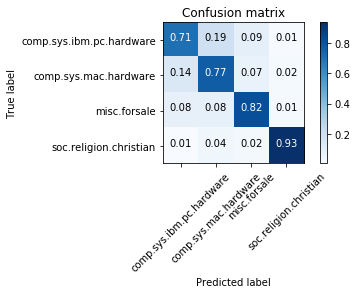

In [132]:
from sklearn.multiclass import OneVsRestClassifier
print("One Vs Rest Classifier - SVC")
print("LSI with min df = 2")
ovr_svc = OneVsRestClassifier(LinearSVC()).fit(lsi_2_train_j, train_set_j.target)
ovr_svc_preds = ovr_svc.predict(lsi_2_test_j)
print("Precision Score: ", precision_score(test_set_j.target, ovr_svc_preds,average='macro'))
print("Recall Score: ", recall_score(test_set_j.target, ovr_svc_preds,average='macro'))
print("Accuracy Score: ", accuracy_score(test_set_j.target, ovr_svc_preds))
plot_confusion_matrix(confusion_matrix(test_set_j.target, ovr_svc_preds), categories, normalize = True)
plt.show()

One Vs Rest Classifier - SVC
NMF with min df = 2
Precision Score:  0.781292426599
Recall Score:  0.779857472033
Accuracy Score:  0.780830670927
Normalized confusion matrix
[[ 0.69387755  0.14540816  0.14030612  0.02040816]
 [ 0.15584416  0.68051948  0.12727273  0.03636364]
 [ 0.10769231  0.05128205  0.81538462  0.02564103]
 [ 0.01005025  0.00251256  0.05778894  0.92964824]]


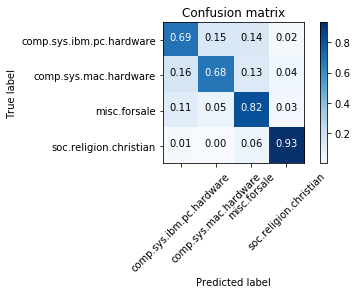

In [131]:
print("One Vs Rest Classifier - SVC")
print("NMF with min df = 2")
ovr_svc = OneVsRestClassifier(LinearSVC()).fit(nmf_train_j, train_set_j.target)
ovr_svc_preds = ovr_svc.predict(nmf_test_j)
print("Precision Score: ", precision_score(test_set_j.target, ovr_svc_preds,average='macro'))
print("Recall Score: ", recall_score(test_set_j.target, ovr_svc_preds,average='macro'))
print("Accuracy Score: ", accuracy_score(test_set_j.target, ovr_svc_preds))
plot_confusion_matrix(confusion_matrix(test_set_j.target, ovr_svc_preds), categories, normalize = True)
plt.show()